## K-Means Cluster Analysis of Fidelity Fund Returns 
### University of Virginia
### DS 7200: Distributed Computing
### Last Updated: August 20, 2023

## Instructions

In this assignment, you will conduct a k-means cluster analysis on a set of Fidelity mutual funds.  
This helps to group similar funds based on their performance (as opposed to their description, which is typical).  
The outline below will walk you through the required steps.  

This assignment is worth a total of **10 POINTS.**

## Data Details 

The file *fido_returns_funds_on_rows.csv* is the processed data for k-means. Additional details about this file: 
- Each row represents a mutual fund  
- Each column represents a trading day (these are used as features)  
- Each value represents the daily percentage change in price between the current trading day and previous trading day

### Load Modules and Read Data into Spark DataFrame

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# Loads data
df = spark.read.csv("fido_returns_funds_on_rows.csv", header=True, inferSchema=True)

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/10/06 21:23:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**(VALUE: 2 POINTS) Assemble the Features into a column. 
Show the first five rows of data ONLY for the features column.
(this should make things easier to read)**

In [9]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
dataset=assembler.transform(df)
dataset.select("features").show(5,truncate=True) #put on true to make more readable for grading

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



**(VALUE: 1 POINT) Set up the k-means model and train the model**  
Use parameters: 
- 3 clusters
- maximum of 10 iterations 
- seed=314

In [4]:
kmeans = KMeans().setK(3).setSeed(314).setMaxIter(10)
model = kmeans.fit(dataset)

24/10/06 21:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


**(VALUE: 2 POINTS) Compute and Print the Silhouette Score**  

In [5]:
predictions = model.transform(dataset)
# Evaluate clustering by computing Silhouette score (between -1  and 1 with 1 as the best clustering)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.42290918461227944


**(VALUE: 2 POINTS) Define a function `kmeans_range()` that does the following:**
- takes an integer representing the lower bound for k
- takes an integer representing the upper bound for k
- take a Spark DataFrame containing training data
- fit K-means with k ranging from lower bound to upper bound, inclusive  
- the other parameters should be the same as earlier 
- for each k, compute the silhouette score
- return a pandas dataframe with columns containing k, silhouette score (each row holds the score for given k)

In [6]:
#****assuming that df contains an already vectorized column labeled features
import pandas as pd

def kmeans_range(lower_bound_k, upper_bound_k, df):
    scores = []
    k_val = []
    for k in range(lower_bound_k,upper_bound_k+1):
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(10)
        model = kmeans.fit(dataset)
        predictions = model.transform(dataset)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        
        scores.append(silhouette)
        k_val.append(k)
    score_df = pd.DataFrame({'k':k_val, 'silhouettte_score':scores})
    return(score_df)

**(VALUE: 1 POINT) Call `kmeans_range` to compute K-means with clusters ranging from 2 to 10 inclusive, printing the resulting dataframe.**

In [7]:
vals = kmeans_range(2, 10, dataset)
print(vals)

24/10/06 21:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB


24/10/06 21:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


24/10/06 21:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1042.5 KiB


24/10/06 21:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


24/10/06 21:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB


24/10/06 21:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB


24/10/06 21:24:27 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


24/10/06 21:24:31 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB


24/10/06 21:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB
    k  silhouettte_score
0   2           0.602396
1   3           0.422909
2   4           0.448951
3   5           0.459352
4   6           0.468879
5   7           0.459371
6   8           0.477168
7   9           0.431599
8  10           0.438814


**(VALUE: 1 POINT) Produce a plot with cluster numbers k on the x-axis, sihouette scores on the y-axis**

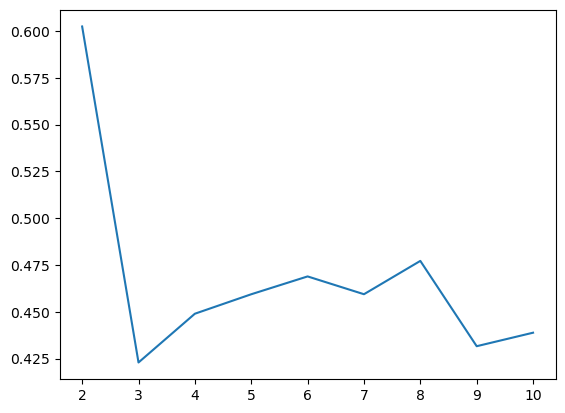

In [8]:
import matplotlib.pyplot as plt
plt.plot(vals.k, vals.silhouettte_score)
plt.show()

**(VALUE: 1 POINT) Based on how the silhouette score is calculated, what is its time complexity? (e.g., O(log n))**  
You can find the definition of the silhouette score in the lecture notes, for example. 

Theoretically the time complexity of the silhouette score is non-linear O(n^2) given it's calculation of pairwise distances.
However, given k clusters with pre-computed means and N points, the time complexity is linear O(Nk), given that for each point N, 
the within cluster distance is computed as well as each between cluster distance for a total of k clusters.

If n = k (aka each point is in it's own cluster), then O(nk) = o(n^2).